In [1]:
%load_ext autoreload
%autoreload 2    

In [2]:
import ges
import sempler
import numpy as np
import scipy.stats as st
from ges.scores.gauss_obs_l0_pen import GaussObsL0Pen
from ges.scores.general import GeneralScore

## Find Causal Graph and get confidence interval [one trial]

In [3]:
d = 20 # of attributes
n = 500 # of datapoints

mu_lb, mu_ub = 0, 10 # range for means of the d components
sig_lb, sig_ub = 0, 10 # range for means of the variance components

## useful fns

In [4]:
def get_parents(x, G):
    parents = []
    for i in range(G.shape[0]):
        if(G[i, x] == 1):
            parents.append(i)
    return parents

In [5]:
def get_all_family(x, G):
    visited = np.zeros(G.shape[0])
    visited[x] = 1
    
    x_parents = get_parents(x, G)
    to_search = x_parents
    reach_from_x = []
    
    while len(to_search):
        to_search_new = []
        
        for y in to_search:
            if(visited[y]):
                continue
            else:
                visited[y] = 1
                
            y_parents = get_parents(y, G)
            to_search_new += y_parents
            reach_from_x.append(y)
            
        to_search = to_search_new
        
    return reach_from_x

## Experiment Definition (assume n >= 30)

In [6]:
def get_conf_interval(a, b, conf_lvl=.95):
    effect_size, resid, _, _ = np.linalg.lstsq(a, b, rcond=None)
    sq_tot_dev = sum([(a_i - np.mean(a))**2 for a_i in a])
    SE = np.sqrt(resid / ((n-2) * sq_tot_dev))
    conf = st.norm.ppf(conf_lvl) * SE
    return (effect_size[0] - conf[0], effect_size[0] + conf[0])

In [7]:
def experiment(d=10, n=500, trials=30, eps_noisy_max=0, eps_abv_thrsh=0, mu_range=(0, 10), sig_range=(1,1)):
    success = 0
    for trial in range(trials):
        # start from empty causal graph, generate data & fit causal graph
        G = np.zeros((d, d))
        data = sempler.LGANM(G, mu_range, sig_range).sample(n=n)
        estimate, score = ges.fit(GeneralScore(data), eps_noisy_max=eps_noisy_max, \
                                  eps_abv_thrsh=eps_abv_thrsh, max_iter=1)
        if(len(np.where(estimate>0)[0]) == 0): # GES found empty graph so it is correct and we stop early
            success += 1
            continue

        # o/w choose arbirary edge & find confidence interval of effect size
        connections = np.where(estimate>0)
        #idx = np.random.randint(0, len(connections[0]))
        
        for idx in range(len(connections)):
            ## check if needs backdoor adj
            backdoor = [x for x in get_all_family(connections[0][idx], estimate) \
                        if x in get_all_family(connections[1][idx], estimate)]
            if(len(backdoor) == 0):
                break

        A = data[:, connections[0][idx]].reshape((n,1))
        for node in backdoor:
            A = np.column_stack((A, data[:, node]))
        b = data[:, connections[1][idx]]
   
        (conf_lb, conf_ub) = get_conf_interval(A, b)

        # check if 0 is in the interval
        if(conf_lb <= 0 and 0 <= conf_ub):
            success+=1
            
    return success / trials

In [8]:
results = {}

In [9]:
for noise_lvl in [0, 100, 200, 400, 800]:
    for d in [2]:
        for n in range(10, 901, 200):
            results[(noise_lvl,d,n)] = []
            for seed in range(5):
                results[(noise_lvl,d,n)].append(experiment(d=d, n=n, eps_noisy_max=noise_lvl/n, \
                                                            eps_abv_thrsh=noise_lvl/n))

            print("noise_lvl=", noise_lvl, "d=",d, ", n=", n," results:", results[(noise_lvl,d,n)])

noise_lvl= 0 d= 2 , n= 10  results: [1.0, 1.0, 1.0, 1.0, 1.0]
noise_lvl= 0 d= 2 , n= 210  results: [1.0, 1.0, 1.0, 1.0, 1.0]
noise_lvl= 0 d= 2 , n= 410  results: [1.0, 1.0, 1.0, 1.0, 1.0]
noise_lvl= 0 d= 2 , n= 610  results: [1.0, 1.0, 1.0, 1.0, 1.0]
noise_lvl= 0 d= 2 , n= 810  results: [1.0, 1.0, 1.0, 1.0, 1.0]
noise_lvl= 100 d= 2 , n= 10  results: [0.8666666666666667, 0.8666666666666667, 0.9333333333333333, 0.9333333333333333, 0.9]
noise_lvl= 100 d= 2 , n= 210  results: [0.9333333333333333, 0.9666666666666667, 0.9333333333333333, 0.9, 0.9666666666666667]
noise_lvl= 100 d= 2 , n= 410  results: [1.0, 0.9, 0.9333333333333333, 1.0, 0.9666666666666667]


KeyboardInterrupt: 

In [60]:
import statistics as stats
import matplotlib.pyplot as plt 

In [38]:
results_per_d_mean = {}

results_mean = np.zeros((1001, 50, 901))
results_CI = np.zeros((1001, 50, 901))

for noise_lvl in [0, 100, 200, 400, 800]:
    for d in [15]:
        for n in range(100, 901, 200):
            results_mean[noise_lvl, d, n] = np.mean(results[(noise_lvl,d,n)]) 
            results_CI[noise_lvl, d, n] = 0.878 * stats.stdev(results[(noise_lvl,d,n)])

In [39]:
d=15

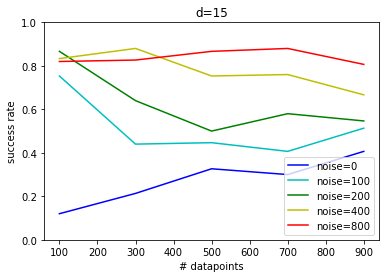

In [41]:
plt.plot(range(100,901, 200), results_mean[0,d,100::200], 'b-', label="noise="+str(0))
#plt.plot(range(100,901, 200), results_mean[0,10,100::200] - results_CI[0,10,100::200], 'b--')
#plt.plot(range(100,901, 200), results_mean[0,10,100::200] + results_CI[0,10,100::200], 'b--')

plt.plot(range(100,901, 200), results_mean[100,d,100::200], 'c-', label="noise="+str(100))
#plt.plot(range(100,901, 200), results_mean[1,10,100::200] - results_CI[1,10,100::200], 'c--')
#plt.plot(range(100,901, 200), results_mean[1,10,100::200] + results_CI[1,10,100::200], 'c--')

plt.plot(range(100,901, 200), results_mean[200,d,100::200], 'g-', label="noise="+str(200))
#plt.plot(range(100,901, 200), results_mean[10,10,100::200] - results_CI[10,10,100::200], 'g--')
#plt.plot(range(100,901, 200), results_mean[10,10,100::200] + results_CI[10,10,100::200], 'g--')

plt.plot(range(100,901, 200), results_mean[400,d,100::200], 'y-', label="noise="+str(400))
#plt.plot(range(100,901, 200), results_mean[100,10,100::200] - results_CI[100,10,100::200], 'y--')
#plt.plot(range(100,901, 200), results_mean[100,10,100::200] + results_CI[100,10,100::200], 'y--')

plt.plot(range(100,901, 200), results_mean[800,d,100::200], 'r-', label="noise="+str(800))

plt.ylim((0,1.))
plt.xlabel('# datapoints')
plt.ylabel('success rate')
plt.legend()
plt.title("d=" + str(d))
plt.savefig("graph_d=15_comparison.pdf");

In [27]:
results = {}

for noise_lvl in [1., 2., 4., 8., 16., 32.]:
    for d in [10, 15,20]:
        for n in range(100, 901, 200):
            results[(noise_lvl,d,n)] = []
            for seed in range(5):
                results[(noise_lvl,d,n)].append(experiment(d=d, n=n, noise_lvls=(noise_lvl/n, noise_lvl/n)))

            print("noise_lvl=", noise_lvl, "d=",d, ", n=", n," results:", results[(noise_lvl,d,n)])

noise_lvl= 0.01 d= 10 , n= 100  results: [0.3333333333333333, 0.23333333333333334, 0.3, 0.26666666666666666, 0.26666666666666666]
noise_lvl= 0.01 d= 10 , n= 300  results: [0.5, 0.5, 0.5, 0.7333333333333333, 0.36666666666666664]
noise_lvl= 0.01 d= 10 , n= 500  results: [0.5, 0.5333333333333333, 0.5666666666666667, 0.6666666666666666, 0.4666666666666667]
noise_lvl= 0.01 d= 10 , n= 700  results: [0.5666666666666667, 0.6333333333333333, 0.6666666666666666, 0.5666666666666667, 0.7666666666666667]
noise_lvl= 0.01 d= 10 , n= 900  results: [0.7666666666666667, 0.7333333333333333, 0.6, 0.5666666666666667, 0.7333333333333333]
noise_lvl= 0.01 d= 15 , n= 100  results: [0.06666666666666667, 0.06666666666666667, 0.2, 0.1, 0.13333333333333333]
noise_lvl= 0.01 d= 15 , n= 300  results: [0.3, 0.3, 0.13333333333333333, 0.23333333333333334, 0.26666666666666666]
noise_lvl= 0.01 d= 15 , n= 500  results: [0.3333333333333333, 0.4666666666666667, 0.43333333333333335, 0.43333333333333335, 0.4]
noise_lvl= 0.01 d

In [28]:
for noise_lvl in [1., 2., 4., 8., 16., 32.]:
    for d in [10, 15,20]:
        for n in range(100, 901, 200):
            results[(noise_lvl,d,n)] = []
            for seed in range(5):
                results[(noise_lvl,d,n)].append(experiment(d=d, n=n, noise_lvls=(noise_lvl/n, noise_lvl/n)))

            print("noise_lvl=", noise_lvl, "d=",d, ", n=", n," results:", results[(noise_lvl,d,n)])

noise_lvl= 1.0 d= 10 , n= 100  results: [0.26666666666666666, 0.26666666666666666, 0.36666666666666664, 0.16666666666666666, 0.3]
noise_lvl= 1.0 d= 10 , n= 300  results: [0.4666666666666667, 0.5666666666666667, 0.43333333333333335, 0.5666666666666667, 0.36666666666666664]
noise_lvl= 1.0 d= 10 , n= 500  results: [0.43333333333333335, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.5]
noise_lvl= 1.0 d= 10 , n= 700  results: [0.6333333333333333, 0.6333333333333333, 0.6, 0.6, 0.5333333333333333]
noise_lvl= 1.0 d= 10 , n= 900  results: [0.7666666666666667, 0.6333333333333333, 0.7, 0.7333333333333333, 0.8]
noise_lvl= 1.0 d= 15 , n= 100  results: [0.06666666666666667, 0.13333333333333333, 0.13333333333333333, 0.06666666666666667, 0.26666666666666666]
noise_lvl= 1.0 d= 15 , n= 300  results: [0.3333333333333333, 0.16666666666666666, 0.3333333333333333, 0.2, 0.06666666666666667]
noise_lvl= 1.0 d= 15 , n= 500  results: [0.26666666666666666, 0.3, 0.43333333333333335, 0.33333333333333

noise_lvl= 16.0 d= 20 , n= 100  results: [0.16666666666666666, 0.13333333333333333, 0.13333333333333333, 0.16666666666666666, 0.13333333333333333]
noise_lvl= 16.0 d= 20 , n= 300  results: [0.1, 0.13333333333333333, 0.06666666666666667, 0.13333333333333333, 0.1]
noise_lvl= 16.0 d= 20 , n= 500  results: [0.23333333333333334, 0.16666666666666666, 0.26666666666666666, 0.13333333333333333, 0.2]
noise_lvl= 16.0 d= 20 , n= 700  results: [0.16666666666666666, 0.16666666666666666, 0.13333333333333333, 0.2, 0.16666666666666666]
noise_lvl= 16.0 d= 20 , n= 900  results: [0.2, 0.36666666666666664, 0.36666666666666664, 0.06666666666666667, 0.16666666666666666]
noise_lvl= 32.0 d= 10 , n= 100  results: [0.4, 0.4666666666666667, 0.4, 0.36666666666666664, 0.5333333333333333]
noise_lvl= 32.0 d= 10 , n= 300  results: [0.5, 0.6333333333333333, 0.5666666666666667, 0.6, 0.4666666666666667]
noise_lvl= 32.0 d= 10 , n= 500  results: [0.5, 0.6333333333333333, 0.6666666666666666, 0.7333333333333333, 0.6]
noise_lv

KeyboardInterrupt: 